In [293]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io as sio
import operator
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import Imputer
from math import log2
from math import sqrt

In [346]:
SPAM = 'dist/spam_data.mat'
TRAIN_CENSUS = 'hw5_census_dist/train_data.csv'
TRAIN_TITANIC = 'hw5_titanic_dist/titanic_training.csv'
TEST_TITANIC = 'hw5_titanic_dist/titanic_testing_data.csv' 
TEST_CENSUS = 'hw5_census_dist/test_data.csv'

In [347]:
spam_data = sio.loadmat(SPAM)
census_tdata = pd.read_csv(TRAIN_CENSUS)
titanic_tdata = pd.read_csv(TRAIN_TITANIC)
census_test = pd.read_csv(TEST_CENSUS)
titanic_test = pd.read_csv(TEST_TITANIC)

# Questions 1 & 2
## Data Cleaning

In [4]:
"""TITANIC TRAINING DATA"""
"""Removed ticket and cabin features"""
titanic_tdata_filtered = titanic_tdata.drop('ticket', 1)
titanic_tdata_filtered = titanic_tdata_filtered.drop('cabin', 1)

"""Row 707 is empty in titanic_training.csv"""
titanic_tdata_filtered = titanic_tdata_filtered.dropna(how='all')

"""Map categories to binary variables [1(a)]"""
tv = DictVectorizer()
vectorized_titanic = tv.fit_transform(titanic_tdata_filtered.to_dict(orient='records'))

# """Replaced unknown values with mean of features [2(b)]"""
# timp = Imputer()
# imputed_titanic = timp.fit_transform(vectorized_titanic)

# ttdata = pd.DataFrame(data=imputed_titanic.toarray(), columns=tv.get_feature_names(), dtype='object')

ttdata = pd.DataFrame(data=vectorized_titanic.toarray(), columns=tv.get_feature_names(), dtype='object')

ttdata['pclass'].fillna(ttdata['pclass'].mode(), inplace=True)
ttdata['sex=male'].fillna(ttdata['sex=male'].mode(), inplace=True)
ttdata['sex=female'].fillna(ttdata['sex=female'].mode(), inplace=True)
ttdata['embarked'].fillna(ttdata['embarked'].mode(), inplace=True)


ttdata['age'].fillna(int(ttdata['age'].mean()), inplace=True)
ttdata['sibsp'].fillna(int(ttdata['sibsp'].mean()), inplace=True)
ttdata['parch'].fillna(int(ttdata['parch'].mean()), inplace=True)
ttdata['fare'].fillna(int(ttdata['fare'].mean()), inplace=True)


In [5]:
"""TITANIC TEST DATA"""

"""Removed ticket and cabin features"""
titanic_test_filtered = titanic_test.drop('ticket', 1)
titanic_test_filtered = titanic_test_filtered.drop('cabin', 1)

"""Map categories to binary variables [1(a)]"""
tv = DictVectorizer()
vectorized_ttest = tv.fit_transform(titanic_test_filtered.to_dict(orient='records'))

"""Replaced unknown values with mean of features [2(b)]"""
timp = Imputer()
timputed = timp.fit_transform(vectorized_ttest)

ttestdata = pd.DataFrame(data=timputed.toarray(), columns=tv.get_feature_names(), dtype='object')

In [6]:
"""CENSUS TRAINING DATA"""

"""Map categories to binary variables [1(a)]"""
cv = DictVectorizer()
vectorized_census = cv.fit_transform(census_tdata.to_dict(orient='records'))

"""Replaced unknown values with mean of features [2(b)]"""
cimp = Imputer()
imputed_census = cimp.fit_transform(vectorized_census)

ctdata = pd.DataFrame(data=imputed_census.toarray(), columns=cv.get_feature_names(), dtype='object')


"""CENSUS TEST DATA"""

"""Map categories to binary variables [1(a)]"""
cv = DictVectorizer()
vectorized_ctest = cv.fit_transform(census_test.to_dict(orient='records'))

"""Replaced unknown values with mean of features [2(b)]"""
cimp = Imputer()
imputed_census_test = cimp.fit_transform(vectorized_ctest)

ctestdata = pd.DataFrame(data=imputed_census_test.toarray(), columns=cv.get_feature_names(), dtype='object')

In [348]:
npstdata = spam_data['training_data']
npstlabels = spam_data['training_labels']

stcombo = np.append(npstdata, npstlabels.T, axis=1)
features = ['pain', 'private', 'bank', 'money', 'drug', 'spam', 'prescription', 'creative', 'height', 
            'featured', 'differ', 'width', 'other', 'energy', 'business', 'message', 'volumes', 'revision', 
            'path', 'meter', 'memo', 'planning', 'pleased', 'record', 'out', ';', '$', '#', '!', '(', '[', '&']
features.append('label')
stdata = pd.DataFrame(data=stcombo, columns=features, dtype='object')

stestdata = pd.DataFrame(data=spam_data['test_data'], columns=features[:-1], dtype='object')

# Decision Tree Abstraction
## Class InternalNode
* ### State
    * Node left, right
    * split_feature [split rule]
    * split_value [split rule]
* ### Methods
    * `predict(data)`
        * given a data point, chooses left or right child based on the split rule
        * traverses starting from this node
    * `is_leaf() { return False }`

## Class LeafNode
* ### State
    * label
* ### Methods
    * `is_leaf() { return True }`

## Class DecisionTree
* ### State
    * root
* ### Methods
    * `impurity(left_label_hist, right_label_hist)`
        * calculates the entropy of a split
    * `segmenter(data, labels)`
        * finds the best split rule using impurity()
        * many different types of segmenters
    * `train(train_data, train_labels, depth_limited)`
        * grows the decision tree
        * uses segmenter to find the best splits
    * `predict(data)`
        * given a data point, traverses the tree starting at the root
    

## Decision Tree and Random Forest Code

In [192]:
class LeafNode:
    def __init__(self, label):
        self.label = label

    def predict(self, data, verbose=False):
        if verbose:
            print(self)
        return self.label

    def is_leaf(self):
        return True

    def __repr__(self):
        return 'Leaf({})'.format(self.label)

class InternalNode:
    def __init__(self, left, right, split_feature, split_value):
        self.left, self.right = left, right
        self.split_feature = split_feature
        self.split_value = split_value

    def predict(self, data, verbose=False):
        if data[self.split_feature] < self.split_value:
            if verbose:
                print('Feature {}: {} < {} -> left'.format(self.split_feature, 
                                                           data[self.split_feature], self.split_value))
            return self.left.predict(data, verbose)
        if verbose:
            print('Feature {}: {} >= {} -> right'.format(self.split_feature, 
                                                       data[self.split_feature], self.split_value))
        return self.right.predict(data, verbose)

    def is_leaf(self):
        return False

    def __repr__(self):
        return 'InternalNode({}, {})'.format(self.split_feature, self.split_value)

class DecisionTree:
    def __init__(self, root=None):
        self.root = root

    def logsp(self, x, y):
        if x == 0:
            return 0
        return x * log2(x / (x + y))

    def impurity(self, C, D, nC, nD):
        c, d = nC - C, nD - D
        return -(self.logsp(C, D) + self.logsp(D, C) + self.logsp(c, d) + self.logsp(d, c)) / (nC + nD)

    def count(self, data, label):
        nC, nD = 0, 0
        for lbl in data[label]:
            if lbl == 0:
                nC += 1
            else:
                nD += 1
        return nC, nD

    def segmenter(self, data, label, is_random_forest=False, m=0):
        """
        For splits on a feature f with a value v,
            left will have samples with f values strictly less than v
            right will have samples with f values greater than or equal to v
        """
        if is_random_forest:
            if m <= 0:
                m = int(sqrt(len(data.axes[1]) - 1))
            elif m < 1:
                m = int((len(data.axes[1]) - 1) * m)
            features = data.drop(label, 1).sample(m, axis=1)
        else:
            features = data.drop(label, 1).axes[1]

        min_entropy, splitf, splitv, spliti = float('inf'), None, None, 0

        for f in features:
            sorted_data_by_f = data.sort_values(f)

            iterv = sorted_data_by_f[f].__iter__()
            iterl = sorted_data_by_f[label].__iter__()

            nC, nD = self.count(sorted_data_by_f, label)

            # keeps track of which value-label pair we're on
            v, lbl, i = next(iterv), next(iterl), 0

            # keeps track of class counts on LEFT
            C, D = 0, 0

            # don't check if all data lies on one side, since then this node should be a leaf (base case of train)
            beta_iter = sorted_data_by_f.drop_duplicates(subset=f, keep='first')[f].__iter__()
            next(beta_iter)

            for beta in beta_iter:
                try:
                    while v != beta:
                        if lbl == 0:
                            C += 1
                        else:
                            D += 1
                        i += 1
                        v, lbl = next(iterv), next(iterl)
                except StopIteration:
                    continue
                entropy = self.impurity(C, D, nC, nD)
                if entropy < min_entropy:
                    min_entropy, splitf, splitv, spliti = entropy, f, beta, i
            # no need to check split on max(beta)+1 since then all elements are on one split (node should be leaf)

        if splitf == None:
            return None, None, splitf, splitv #, spliti

        sorted_data = data.sort_values(splitf)
        left = sorted_data.iloc[:spliti]
        right = sorted_data.iloc[spliti:]

        return left, right, splitf, splitv #, spliti

    def train(self, train_data, label, depth_limited=float('inf'), is_random_forest=False, m=0):
        def grow_tree(train_data, label, depth_limited=float('inf'), is_random_forest=False, m=0):
            labels = train_data[label].unique()
            if depth_limited == 0 or len(labels) == 1:
                return LeafNode(labels[0])

            left_data, right_data, split_feature, split_value = self.segmenter(train_data, label, is_random_forest, m)

            if left_data is None:
                lbl = train_data[label].value_counts().argmax()
                return LeafNode(lbl)

            left = grow_tree(left_data, label, depth_limited - 1, is_random_forest, m)
            right = grow_tree(right_data, label, depth_limited - 1, is_random_forest, m)
            return InternalNode(left, right, split_feature, split_value)
        self.root = grow_tree(train_data, label, depth_limited, is_random_forest, m)

    def predict(self, data, verbose=False):
        return self.root.predict(data, verbose)

class RandomForest:
    def __init__(self, n=150):
        self.n = n
        self.forest = []

    def train(self, train_data, label, depth_limited=float('inf'), m=0, bagging=0):
        if bagging == 0:
             bagging = len(train_data)
        for i in range(self.n):
            t = DecisionTree()
            t.train(train_data.sample(bagging, replace=True), label, depth_limited, True, m)
            self.forest.append(t)

    def predict(self, data):
        predictions, count0, count1 = [], 0, 0
        for t in self.forest:
            predictions.append(t.predict(data))
            if predictions[-1] == 0:
                count0 += 1
            else:
                count1 += 1
        if count0 > count1:
            return 0
        return 1

# Question 3: Implementation Details
(a) Categorical features were mapped to binary variables as suggested in Appendix 1.a. For the Titanic dataset, missing values of categorical data were replaced with the mode and for continuous features with the mean while for all other datasets missing values were replaced with just the mean.

(b) The stopping criteria used was having pure nodes (all samples in a node belonging to the same class) or having an empty child (this would be the left); however, a depth-limited criteria was also implemented and used for random forests.

(c) Nothing special was done to speed up training.

(d) The `segmenter` method of `DecisionTree` was modified to sample features for `RandomForest`. A `RandomForest` class was created and held a list of `DecisionTree`. Each `DecisionTree` of the list was trained with bagging, and bagging was done in `RandomForest#train`.

(e) Nothing out of the ordinary was implemented.

# Question 4: Performance Evaluation
Kaggle username: cschon

#### Titanic
* Decision Tree
    * Training: 0.9737
    * Validation: 0.7755
* Random Forest
    * Training: 0.8632
    * Validation: 0.8163
* Kaggle (Random Forest): 	0.80645

#### Census
* Decision Tree
    * Training: 0.8296
    * Validation: 0.8142
* Random Forest
    * Training: 0.8607
    * Validation: 0.8551
* Kaggle (Decision Tree): 	0.81338

#### Spam
* Decision Tree
    * Training: 0.7724
    * Validation: 0.7722
* Random Forest
    * Training: 0.8009
    * Validation: 0.8084
* Kaggle (Decision Tree): 0.76840

In [302]:
def train(data, label, model, depth_limited=float('inf'), n=None):
    shuffled_data = data.sample(frac=1)
    tvnum = int(len(shuffled_data) // 20)
    vdata = shuffled_data[:tvnum]
    tdata = shuffled_data[tvnum:]
    
    if n == None:
        m = model()
    else:
        m = model(n)
    m.train(tdata, label, depth_limited)
    return m, vdata, tdata
    
def evaluate(data, label, model, depth_limited=float('inf'), n=None):
    m, vdata, tdata = train(data, label, model, depth_limited, n)

    vcorrect = 0
    for _, vsample in vdata.iterrows():
        if m.predict(vsample) == vsample[label]:
            vcorrect += 1
            
    tcorrect = 0      
    for _, tsample in tdata.iterrows():
        if m.predict(tsample) == tsample[label]:
            tcorrect += 1
            
    return vcorrect / len(vdata), tcorrect / len(tdata), m

def print_evaluate(data, label, model, depth_limited=float('inf')):
    v, t, m = evaluate(data, label, model, depth_limited)
    print('Training Accuracy: {}\nValidation Accuracy: {}'.format(t, v))
    return m

In [158]:
tdt = print_evaluate(ttdata, 'survived', DecisionTree)

Training Accuracy: 0.9736842105263158
Validation Accuracy: 0.7755102040816326


In [193]:
cdt = print_evaluate(ctdata, 'label', DecisionTree, 10)

Training Accuracy: 0.8296448790530108
Validation Accuracy: 0.8141809290953546


In [303]:
sdt = print_evaluate(stdata, 'label', DecisionTree, 10)

Training Accuracy: 0.772438601945197
Validation Accuracy: 0.7721518987341772


In [96]:
trf = print_evaluate(ttdata, 'survived', RandomForest)

Training Accuracy: 0.8631578947368421
Validation Accuracy: 0.8163265306122449


In [97]:
crf = print_evaluate(ctdata, 'label', RandomForest, 10)

Training Accuracy: 0.8606536284096757
Validation Accuracy: 0.8551344743276283


In [304]:
srf = print_evaluate(stdata, 'label', RandomForest, 10)

Training Accuracy: 0.8008615712572723
Validation Accuracy: 0.8084388185654009


## Kaggle

In [39]:
kaggle_trf = RandomForest()
kaggle_trf.train(ttdata, 'survived')

In [34]:
f = open('titanic.csv', 'w')
f.write("Id,Category\n")
i = 1
for _, vsample in ttestdata.iterrows():
    f.write("{},{}\n".format(i, int(kaggle_trf.predict(vsample))))
    i += 1
f.close()

In [58]:
kaggle_cdt = DecisionTree()
kaggle_cdt.train(ctdata, 'label')

In [60]:
f = open('census.csv', 'w')
f.write("Id,Category\n")
i = 1
for _, vsample in ctestdata.iterrows():
    f.write("{},{}\n".format(i, int(kaggle_cdt.predict(vsample))))
    i += 1
f.close()

In [305]:
kaggle_sdt = DecisionTree()
kaggle_sdt.train(stdata, 'label')

In [306]:
f = open('spam.csv', 'w')
f.write("Id,Category\n")
i = 0
for _, vsample in stestdata.iterrows():
    f.write("{},{}\n".format(i, int(kaggle_sdt.predict(vsample))))
    i += 1
f.close()

# Question 5: Spam Writeup

## Question 5(a): Features
No other features or feature transformations were used.

## Question 5(b): Decision Tree Splits

("!") < 1  
("(") >= 1  
("money") < 1  
("featured") < 1  
("energy") < 1  
("$") < 1  
("spam") < 1  
("bank") < 2  
("prescription") < 1  
("[") < 1  
Ham (class 0)  

("!") >= 1  
("energy") < 1  
("money") < 1  
("(") < 1  
("!") < 33  
("prescription") < 1  
("$") >= 1  
("volumes") < 1  
("&") < 4  
("meter") < 1  
Ham (class 1)  

In [252]:
samples = stdata.sample(10)
ham = samples[samples['label'] == 0].iloc[0]
spam = samples[samples['label'] == 1].iloc[0]

In [253]:
print(list(ham), '\n')
print(list(spam))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0] 

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]


In [254]:
print(sdt.predict(ham, True), ham['label'])

Feature !: 0.0 < 1.0 -> left
Feature (: 1.0 >= 1.0 -> right
Feature money: 0.0 < 1.0 -> left
Feature featured: 0.0 < 1.0 -> left
Feature energy: 0.0 < 1.0 -> left
Feature $: 0.0 < 1.0 -> left
Feature spam: 0.0 < 1.0 -> left
Feature bank: 0.0 < 2.0 -> left
Feature prescription: 0.0 < 1.0 -> left
Feature [: 0.0 < 1.0 -> left
Leaf(0.0)
0.0 0.0


In [255]:
print(sdt.predict(spam, True), spam['label'])

Feature !: 1.0 >= 1.0 -> right
Feature energy: 0.0 < 1.0 -> left
Feature money: 0.0 < 1.0 -> left
Feature (: 0.0 < 1.0 -> left
Feature !: 1.0 < 33.0 -> left
Feature prescription: 0.0 < 1.0 -> left
Feature $: 1.0 >= 1.0 -> right
Feature volumes: 0.0 < 1.0 -> left
Feature &: 1.0 < 4.0 -> left
Feature meter: 0.0 < 1.0 -> left
Leaf(1.0)
1.0 1.0


## Question 5(c): Random Forest most common split made at root node of trees

In [263]:
def root_splits(rf):
    root_splits = {}
    for t in rf.forest:
        pair = (t.root.split_feature, t.root.split_value)
        if pair not in root_splits:
            root_splits[pair] = 0
        root_splits[pair] += 1
    
    split_ranking = sorted(root_splits.items(), key=operator.itemgetter(1), reverse=True)
    for s in split_ranking:
        print('(\"{}\"), {} ({} trees)'.format(s[0][0], int(s[0][1]), s[1]))

In [264]:
root_splits(srf)

("money"), 1 (29 trees)
("!"), 1 (20 trees)
("energy"), 1 (18 trees)
("("), 1 (17 trees)
("$"), 1 (12 trees)
("featured"), 1 (10 trees)
("&"), 1 (8 trees)
("prescription"), 1 (7 trees)
("meter"), 1 (7 trees)
("private"), 1 (3 trees)
("volumes"), 1 (3 trees)
("pain"), 1 (3 trees)
("memo"), 1 (3 trees)
(";"), 2 (2 trees)
("spam"), 1 (2 trees)
(";"), 4 (2 trees)
("creative"), 1 (2 trees)
("drug"), 1 (1 trees)
("differ"), 1 (1 trees)


# Question 6: Census Writeup

## Question 6(a): Features
Other than transforming categorical features to binary variables, no other features or feature transformations were used.  

## Question 6(b): Decision Tree Splits

("marital-status=Married-civ-spouse") < 1  
("capital-gain") < 7262  
("education-num") < 13  
("age") >= 27  
("hours-per-week") < 41  
("capital-loss") < 2231  
("occupation=Prof-specialty") < 1  
("occupation=Exec-managerial") < 1  
("sex=Female") < 1  
("age") < 42  
[< $50k] (class 0)

("marital-status=Married-civ-spouse") >= 1  
("education-num") >= 12  
("capital-gain") < 5178  
("capital-loss") < 1825  
("hours-per-week") >= 31  
("age") < 34  
("age") >= 28  
("occupation=Exec-managerial") < 1  
("education=Assoc-acdm") < 1  
("native-country=United-States") >= 1  
[>= $50k] (class 1)  

In [198]:
samples = ctdata.sample(10)
poor = samples[samples['label'] == 0].iloc[0]
rich = samples[samples['label'] == 1].iloc[0]

In [202]:
print(cdt.predict(poor, True), poor['label'])

Feature marital-status=Married-civ-spouse: 0.0 < 1.0 -> left
Feature capital-gain: 0.0 < 7262.0 -> left
Feature education-num: 10.0 < 13.0 -> left
Feature age: 30.0 >= 27.0 -> right
Feature hours-per-week: 40.0 < 41.0 -> left
Feature capital-loss: 0.0 < 2231.0 -> left
Feature occupation=Prof-specialty: 0.0 < 1.0 -> left
Feature occupation=Exec-managerial: 0.0 < 1.0 -> left
Feature sex=Female: 0.0 < 1.0 -> left
Feature age: 30.0 < 42.0 -> left
Leaf(0.0)
0.0 0.0


In [204]:
print(cdt.predict(rich, True), rich['label'])

Feature marital-status=Married-civ-spouse: 1.0 >= 1.0 -> right
Feature education-num: 13.0 >= 12.0 -> right
Feature capital-gain: 0.0 < 5178.0 -> left
Feature capital-loss: 0.0 < 1825.0 -> left
Feature hours-per-week: 40.0 >= 31.0 -> right
Feature age: 31.0 < 34.0 -> left
Feature age: 31.0 >= 28.0 -> right
Feature occupation=Exec-managerial: 0.0 < 1.0 -> left
Feature education=Assoc-acdm: 0.0 < 1.0 -> left
Feature native-country=United-States: 1.0 >= 1.0 -> right
Leaf(1.0)
1.0 1.0


## Question 6(c): Random Forest most common split made at root node of trees

In [265]:
root_splits(crf)

("marital-status=Married-civ-spouse"), 1 (12 trees)
("relationship=Husband"), 1 (12 trees)
("education-num"), 13 (11 trees)
("marital-status=Never-married"), 1 (10 trees)
("relationship=Own-child"), 1 (9 trees)
("relationship=Not-in-family"), 1 (9 trees)
("capital-gain"), 7298 (9 trees)
("sex=Male"), 1 (7 trees)
("age"), 28 (7 trees)
("occupation=Other-service"), 1 (7 trees)
("sex=Female"), 1 (6 trees)
("education=Masters"), 1 (5 trees)
("age"), 29 (5 trees)
("education=Bachelors"), 1 (5 trees)
("education=Doctorate"), 1 (4 trees)
("marital-status=Divorced"), 1 (4 trees)
("relationship=Unmarried"), 1 (3 trees)
("capital-loss"), 1825 (3 trees)
("capital-gain"), 5178 (3 trees)
("occupation=Prof-specialty"), 1 (3 trees)
("hours-per-week"), 42 (2 trees)
("occupation=Adm-clerical"), 1 (2 trees)
("hours-per-week"), 41 (2 trees)
("marital-status=Separated"), 1 (1 trees)
("education=10th"), 1 (1 trees)
("occupation=Exec-managerial"), 1 (1 trees)
("education=HS-grad"), 1 (1 trees)
("education-n

## Question 6(d) Depth Hyperparameter Tuning

In [350]:
def data_split(data):
    shuffled_data = data.sample(frac=1)
    vdata = shuffled_data[:20]
    tdata = shuffled_data[20:100]
    return tdata, vdata

def train(data, label, model, depth_limited=float('inf'), n=None):
    if n == None:
        m = model()
    else:
        m = model(n)
    m.train(tdata, label, depth_limited)
    return m
    
def evaluate(tdata, vdata, label, model, depth_limited=float('inf'), n=None):
    m = train(tdata, label, model, depth_limited, n)

    vcorrect = 0
    for _, vsample in vdata.iterrows():
        if m.predict(vsample) == vsample[label]:
            vcorrect += 1
            
    tcorrect = 0      
    for _, tsample in tdata.iterrows():
        if m.predict(tsample) == tsample[label]:
            tcorrect += 1
            
    return vcorrect / len(vdata), tcorrect / len(tdata)

In [351]:
tdata, vdata = data_split(ctdata)

In [362]:
accuracies = []
for depth in range(1, 41):
    vcorrect, tcorrect = evaluate(tdata, vdata, 'label', DecisionTree, depth)
    accuracies.append(vcorrect)

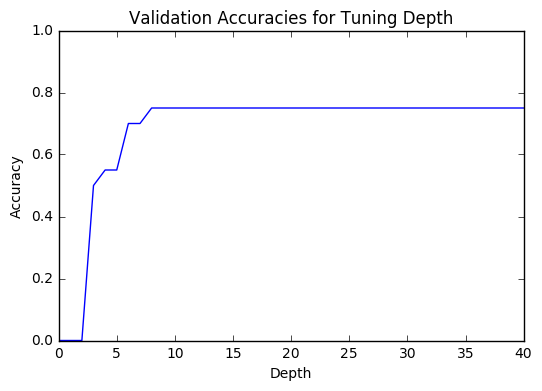

In [364]:
accuracies = [0] + accuracies
plt.xlim([0, 40])
plt.ylim([0, 1])
# plt.xlim(xmin=1) 
plt.plot(accuracies)
plt.title('Validation Accuracies for Tuning Depth')
ax = plt.gca()

plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.show()

Depth 7 and beyond had the highest validation accuracy. This is probably due to the small training set, which may have been completely separated by depth 7. Thus, depths 7 and beyond may have overfit on the training set.

# Question 7: Titanic Writeup

In [365]:
shallow_tdt = DecisionTree()
shallow_tdt.train(ttdata, 'survived', 3)

In [367]:
q = []
q.append(shallow_tdt.root)
while len(q) > 0:
    n = q.pop(0)
    print(n)
    if not n.is_leaf():
        q.append(n.left)
        q.append(n.right)


InternalNode(sex=female, 1.0)
InternalNode(age, 10.0)
InternalNode(pclass, 3.0)
InternalNode(sibsp, 3.0)
InternalNode(pclass, 2.0)
InternalNode(embarked=S, 1.0)
InternalNode(fare, 23.45)
Leaf(1.0)
Leaf(0.0)
Leaf(1.0)
Leaf(0.0)
Leaf(1.0)
Leaf(1.0)
Leaf(1.0)
Leaf(0.0)
